In [57]:
import tensorflow as tf
print(tf.__version__)
import tf_keras as keras
# from tensorflow import keras
# import tf_keras as keras
# import keras as keras

# from tf.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers import Conv1D, Dense, Flatten, Input, LSTM, Dropout, BatchNormalization, TimeDistributed, Bidirectional
# from tensorflow.keras.utils.np_utils import to_categorical

import pandas as pd
import numpy as np
from pathlib import Path
import random
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

2.19.0


In [54]:
# import os
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import random


# # Parameters
# WINDOW_SIZE = 150
# # LONG_WINDOW_SIZE = 150
# STEP_SIZE = 150
# TOLERANCE = 0.1
# MAX = 20000
# DATA_DIR = str(Path.cwd().parent.parent / 'Reffit' / 'Processed')
# LABELS = []
# X = []
# y = []
# well_represented = ['Fridge','Freezer','Washing Machine','Washer Dryer','Tumble Dryer','Dishwasher','Microwave','Toaster','Kettle',
#                 'Computer','Television','Electric Heater','Hi-Fi','Overhead Fan']

# def extract_windows(signal):
#     signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
#     windows = []
#     for start in range(0, len(signal) - WINDOW_SIZE, STEP_SIZE):
#         window = signal[start:start + WINDOW_SIZE]
#         windows.append(window)
#     return windows

# def process_file(file_path, label_idx):
#     print(f"Processing file: {file_path}")
#     df = pd.read_csv(file_path)
#     with open(file_path) as f:
#         appliance_name = f.readline().strip().split(",")[1]

#     if appliance_name not in df.columns:
#         return []

#     signal = df[appliance_name].fillna(0).values.astype(np.float32)
#     return [(window, label_idx) for window in extract_windows(signal)]

# def load_balanced_dataset(data_dir, well_represented=well_represented):
#     global LABELS, X, y

#     label_map = {name: i for i, name in enumerate(well_represented)}
#     all_windows = {label: [] for label in well_represented}

#     # Step 1: Load all data first
#     for class_dir in sorted(Path(data_dir).iterdir()):
#         if not class_dir.is_dir():
#             continue
#         class_name = class_dir.name
#         if class_name not in well_represented:
#             continue
#         label_idx = label_map[class_name]
#         if class_name not in LABELS:
#             LABELS.append(class_name)
#         for file in class_dir.glob("*.csv"):
#             windows = process_file(file, label_idx)
#             all_windows[class_name].extend(windows)

#     # Step 2: Select reference class and determine target range
#     ref_class = random.choice(well_represented)
#     original_ref_count = len(all_windows[ref_class])
#     ref_count = min(MAX, original_ref_count)
#     print(f"Reference class: {ref_class} (using {ref_count} windows, originally had {original_ref_count})")

#     min_required = int(ref_count * (1 - TOLERANCE))
#     max_allowed = int(ref_count * (1 + TOLERANCE))
#     cap = min(MAX, max_allowed)


#     # Step 3: Apply sampling per class
#     for label in well_represented:
#         class_windows = all_windows[label]
#         # needed = random.randint(min_required, cap)
#         needed = MAX

#         if len(class_windows) >= needed:
#             chosen = random.sample(class_windows, needed)
#         else:
#             repeat_count = (needed // len(class_windows)) + 1
#             extended = class_windows * repeat_count
#             chosen = extended[:needed]
#             chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
#                       for (w, lbl) in chosen]

#         for window, label_idx in chosen:
#             X.append(window)
#             y.append(label_idx)

#         print(f"{label}: {len(chosen)} samples")

#     print("\nClass balance (target ±{:.1f}%, max cap = {}):".format(TOLERANCE * 100, MAX))
#     for label in well_represented:
#         print(f"{label}: {sum(np.array(y) == label_map[label])} windows")

#     X_np = np.array(X)[..., np.newaxis]
#     y_np = to_categorical(y, num_classes=len(LABELS))
#     return X_np, y_np


# X, y = load_balanced_dataset(DATA_DIR)

In [96]:
class ApplianceDatasetLoader:
    def __init__(self, data_dir, segment, well_represented=None, window_size=150, step_size=150, max_per_class=10000, tolerance=0.1):
        self.data_dir = Path(data_dir)
        self.segment = segment
        self.window_size = window_size
        self.step_size = step_size
        self.max_per_class = max_per_class
        self.tolerance = tolerance
        self.well_represented = well_represented or []
        self.label_map = {name: i for i, name in enumerate(self.well_represented)}
        self.X = []
        self.y = []
        self.labels = []

    def _extract_windows(self, signal):
        signal = signal / np.max(np.abs(signal)) if np.max(np.abs(signal)) > 0 else signal
        windows = []
        if len(signal) < self.window_size:
            padding = self.window_size - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')
            return [signal]  # Return the padded signal as a single window
        for start in range(0, len(signal) - self.window_size, self.step_size):
            window = signal[start:start + self.window_size]
            windows.append(window)
            # print(f"Extracted window of size {len(window)} at start index {start}")
        return windows

    def _process_file(self, file_path, label_idx):
        print(f"Processing file: {file_path}")
        # file_path = os.path.join( file_path,self.segment)
        df = pd.read_csv(file_path)
        with open(file_path) as f:
            appliance_name = f.readline().strip().split(",")[0]

        if appliance_name not in df.columns:
            print(f"Warning: Appliance '{appliance_name}' not found in file {file_path}. Skipping...")
            return []

        signal = df[appliance_name].fillna(0).values.astype(np.float32)
        # print([(window, label_idx) for window in self._extract_windows(signal)])
        return [(window, label_idx) for window in self._extract_windows(signal)]

    def _load_windows(self):
        all_windows = {label: [] for label in self.well_represented}

        # Iterate over each appliance directory under Processes
        for appliance_dir in sorted(self.data_dir.iterdir()):
            if not appliance_dir.is_dir():
                continue

            appliance_name = appliance_dir.name
            if appliance_name not in self.well_represented:
                continue

            # # Compose the segment directory path (short_segments or long_segments)
            # segment = random.choice(['short_segments', 'long_segments'])
            # segment_dir = os.path.join(appliance_dir, segment)
            # segment_dir = Path(segment_dir)
            # if not segment_dir.exists() or not segment_dir.is_dir():
            #     print(f"Warning: Segment directory does not exist: {segment_dir}")
            #     continue

            label_idx = self.label_map[appliance_name]

            if appliance_name not in self.labels:
                self.labels.append(appliance_name)

            # Load CSV files from the segment directory
           
            csv_files = list(appliance_dir.glob("*.csv"))
            for csv_file in csv_files:
            # Randomly decide whether to use this file from this segment
                if random.choice([True, False]):
                    windows = self._process_file(csv_file, label_idx)
                    all_windows[appliance_name].extend(windows)

        return all_windows


    def _balance_dataset(self, all_windows):
        ref_class = random.choice(self.well_represented)
        original_ref_count = len(all_windows[ref_class])
        ref_count = min(self.max_per_class, original_ref_count)

        min_required = int(ref_count * (1 - self.tolerance))
        cap = int(ref_count * (1 + self.tolerance))

        for label in self.well_represented:
            class_windows = all_windows[label]
            if len(class_windows) == 0:
                print(f"Warning: No samples found for class '{label}'. Skipping...")
                continue

            needed = self.max_per_class

            if len(class_windows) >= needed:
                chosen = random.sample(class_windows, needed)
            else:
                repeat_count = (needed // len(class_windows)) + 1
                extended = class_windows * repeat_count
                chosen = extended[:needed]
                chosen = [(w + np.random.normal(0, 0.01, size=w.shape).astype(np.float32), lbl)
                          for (w, lbl) in chosen]

            for window, label_idx in chosen:
                self.X.append(window)
                self.y.append(label_idx)

            print(f"{label}: {len(chosen)} samples")

        print("\nClass balance (±{:.1f}%):".format(self.tolerance * 100))
        for label in self.well_represented:
            count = sum(np.array(self.y) == self.label_map[label])
            print(f"{label}: {count} windows")

    def load_dataset(self):
        all_windows = self._load_windows()
        self._balance_dataset(all_windows)

        X_np = np.array(self.X)[..., np.newaxis]
        y_np = to_categorical(self.y, num_classes=len(self.label_map))
        return X_np, y_np, self.labels

In [97]:
DATA_DIR = Path.cwd().parent.parent / 'Reffit' / 'Processed'
WELL_REPRESENTED = [
    'Fridge', 'Freezer', 'Washing Machine', 'Washer Dryer', 'Tumble Dryer',
    'Dishwasher', 'Microwave', 'Toaster', 'Kettle', 'Computer',
    'Television', 'Electric Heater', 'Hi-Fi', 'Overhead Fan'
]
WINDOW_SIZE = 150

short_segment_loader = ApplianceDatasetLoader(
    data_dir=DATA_DIR,
    segment="short_segments",
    well_represented=WELL_REPRESENTED,
    window_size=WINDOW_SIZE,
    step_size=50,
    max_per_class=10000,
    tolerance=0.1
)

X_short, y_short, LABELS = short_segment_loader.load_dataset()



Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_1.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_10.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_101.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_103.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_104.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\Processed\Computer\Computer_House_1.csv_105.csv
Processing file: c:\Users\niran\OneDrive\Documents\UL\Edge Computing\Project\NILM\NILM_Project\Reffit\P

In [99]:

# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)
X_train_short, X_temp_short, y_train_short, y_temp_short = train_test_split(X_short, y_short, test_size=0.4, random_state=42)
X_val_short, X_test_short, y_val_short, y_test_short = train_test_split(X_temp_short, y_temp_short, test_size=0.3, random_state=42)

# X_train_long, X_temp_long, y_train_long, y_temp_long = train_test_split(X_long, y_long, test_size=0.4, random_state=42)
# X_val_long, X_test_long, y_val_long, y_test_long = train_test_split(X_temp_long, y_temp_long, test_size=0.3, random_state=42)

def print_class_distribution(y_set, set_name):
    class_counts = np.sum(y_set, axis=0)
    print(f"\nClass distribution in {set_name} set:")
    for idx, count in enumerate(class_counts):
        print(f"{LABELS[idx]:<20}: {int(count)} samples")

# Print stats
print_class_distribution(y_train_short, "SHORT TRAIN")
print_class_distribution(y_val_short, "SHORT VALIDATION")
print_class_distribution(y_test_short, "SHORT TEST")

# Print stats
# print_class_distribution(y_train_long, "LONG TRAIN")
# print_class_distribution(y_val_long, "LONG VALIDATION")
# print_class_distribution(y_test_long, "LONG TEST")




Class distribution in SHORT TRAIN set:
Computer            : 6038 samples
Dishwasher          : 6050 samples
Electric Heater     : 6012 samples
Freezer             : 5896 samples
Fridge              : 5935 samples
Hi-Fi               : 6003 samples
Kettle              : 6054 samples
Microwave           : 5931 samples
Overhead Fan        : 6036 samples
Television          : 5988 samples
Toaster             : 6011 samples
Tumble Dryer        : 5965 samples
Washer Dryer        : 6066 samples
Washing Machine     : 6015 samples

Class distribution in SHORT VALIDATION set:
Computer            : 2804 samples
Dishwasher          : 2757 samples
Electric Heater     : 2812 samples
Freezer             : 2892 samples
Fridge              : 2810 samples
Hi-Fi               : 2769 samples
Kettle              : 2769 samples
Microwave           : 2844 samples
Overhead Fan        : 2757 samples
Television          : 2805 samples
Toaster             : 2785 samples
Tumble Dryer        : 2844 samples
Washe

In [102]:
from Conv1D_GLU import Conv1DGLU
from ResidualBlock import ResidualBlock
from keras.models import Model
from keras.layers import Add

def build_glu_cnn_lstm_model(window_size, num_classes):
    input_layer = Input(shape=(window_size, 1))
    print(f"Input shape: {input_layer.shape}")

    # x = Conv1DGLU(filters=64, kernel_size=5)(input_layer)
    x = ResidualBlock(Conv1DGLU(filters=64, kernel_size=5), filters=64)(input_layer)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    print(f"Input shape: {x.shape}")
    # input_layer = x  # Save the input for residual connection
    # x2 = Conv1DGLU(filters=128, kernel_size=3)(x)
    x = ResidualBlock(Conv1DGLU(filters=128, kernel_size=3), filters=128)(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)

    x = Dropout(0.2)(x)

    # Optional LSTM
    x = LSTM(64)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy'
    patience=5,               # number of epochs with no improvement before stopping
    restore_best_weights=True
)

In [103]:
model = build_glu_cnn_lstm_model(WINDOW_SIZE, num_classes=len(LABELS))
model.summary()

history_short = model.fit(
    X_train_short, y_train_short,
    validation_data=(X_val_short, y_val_short),
    epochs=10,
    batch_size=64,
    verbose=1
)


Input shape: (None, 150, 1)
Input shape: (None, 75, 64)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_20               │ (None, 150, 64)        │           896 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_21               │ (None, 75, 128)        │        57,728 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 37, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,158 (461.55 KB)

 Trainable params: 118,158 (461.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 300/1313 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.1128 - loss: 2.5282

KeyboardInterrupt: 

In [84]:
history_long = model.fit(
    X_train_long, y_train_long,
    validation_data=(X_val_long, y_val_long),
    epochs=10,
    batch_size=64,
    verbose=1
)

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 62s 47ms/step - accuracy: 0.1431 - loss: 2.6395 - val_accuracy: 0.2393 - val_loss: 2.0472
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step - accuracy: 0.2138 - loss: 2.0852 - val_accuracy: 0.2626 - val_loss: 1.8386
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step - accuracy: 0.2505 - loss: 1.8997 - val_accuracy: 0.2949 - val_loss: 1.7499
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step - accuracy: 0.2694 - loss: 1.8120 - val_accuracy: 0.3045 - val_loss: 1.7039
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 57s 44ms/step - accuracy: 0.2774 - loss: 1.7750 - val_accuracy: 0.3156 - val_loss: 1.6775
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.2930 - loss: 1.7489 - val_accuracy: 0.2902 - val_loss: 1.7294
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.2820 - loss: 1.7653 - val_accuracy: 0.3056 - val_loss: 1.6762
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 56s 43ms/step - accuracy: 0.2708 -

KeyboardInterrupt: 

In [72]:
predictions_short = model.predict(X_test_short)
short_probs = np.argmax(predictions_short,axis = 1)

predictions_long = model.predict(X_test_long)
long_probs = np.argmax(predictions_long,axis = 1)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


In [73]:
class DualSegmentClassifier:
    def __init__(self, short_model, long_model, alpha=0.5):
        self.short_model = short_model
        self.long_model = long_model
        self.alpha = alpha

    def predict(self, short_input, long_input):
        short_probs = self.short_model.predict(short_input)
        long_probs = self.long_model.predict(long_input)
        return (self.alpha * short_probs + (1 - self.alpha) * long_probs)



In [74]:
dual_classifier = DualSegmentClassifier(model, model, alpha=0.5)
final_predictions = dual_classifier.predict(X_test_short, X_test_long)
final_probs = np.argmax(final_predictions, axis=1)



1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


In [76]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

Confusion matrix, without normalization
[[1921    1  102    8  113  146    0    0    7    0    0   28   28    8]
 [1354    2  111   12  331  147    2    0  251   19    0  119  130    0]
 [1539    0  130    6  350  206    0    0   27    1    0   52   35   10]
 [1540   11  153    5  234  194    0    0   79   15    0   58   72    0]
 [1894    5   67    4   48  197    0    0   20    1    0   60   54    5]
 [1560    5  130    8  406  150    0    0   13    0    0   41  152    6]
 [1484    7   43   11   82   91    0    0   77    3    0  241  293   25]
 [1524    3   10    0   13   54    0    0   14    3    0  273  516    6]
 [1580   29   24    0   22  110    0    0    6    6    0  182  435    2]
 [1404    4   48    2  437   92    0    0   32    8    0  149  133   15]
 [1213    3  139   13  205  238    0    0  174   11    0  142  188   41]
 [1629    0  184    0   35  166    0    0   49    5    0  247   55   47]
 [1658    0   41    0  101  327    0    0   36    0    0  118  210   25]
 [1641    0

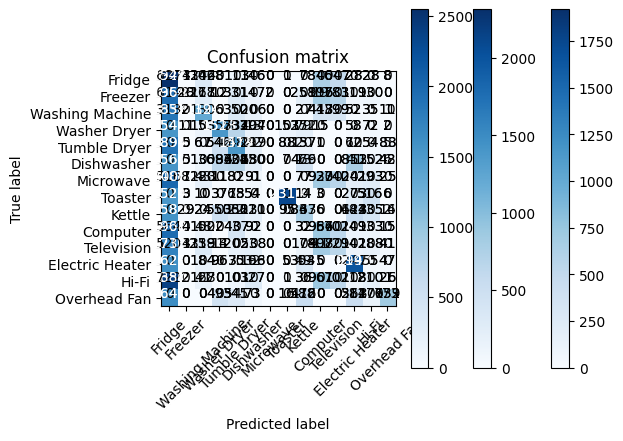

In [77]:
y_true_short = np.argmax(y_test_short, axis=1)
cm_short = confusion_matrix(y_true_short, short_probs)
plot_confusion_matrix(cm_short,classes = WELL_REPRESENTED)

y_true_long = np.argmax(y_test_short, axis=1)
cm_long = confusion_matrix(y_true_long, long_probs)
plot_confusion_matrix(cm_long,classes = WELL_REPRESENTED)

cm = cm_long + cm_short
plot_confusion_matrix(cm, classes=WELL_REPRESENTED)
